In [1]:
# imports some utilities ...

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
# defines important variables ...

from tensorflow.keras import layers, models
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

input_size_1 = 128
input_size_2 = 128
dim = 3
kernel_size = (3, 3)
strides = (1, 1)
epochs = 40
learning_rate = 0.0001
output_size = 1 # For sigmoid activation its betwteen 0 and 1 

Num GPUs Available:  1


In [3]:
#defines routes

root_dir = "./"
data_dir = root_dir + "dataset/chest_xray/"

training_images_dir =  data_dir + "train/"
test_images_dir = data_dir + "test/"

training_images_dir

'./dataset/chest_xray/train/'

## Let's visualizate our data

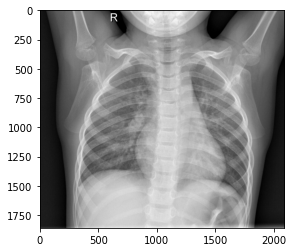

In [4]:
# Load an color image in grayscale
img = cv2.imread(training_images_dir + "/NORMAL/IM-0115-0001.jpeg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # RGB colorisation
plt.imshow(img_rgb)

In [5]:
type(img)
img_rgb.shape

(1858, 2090, 3)

In [6]:
list_img = []

def number_of_files(startpath):
    """Print the folder sutructure of a given folder"""
    for root, dirs, files in os.walk(startpath):
        list_img.append(files)

In [7]:
list_img = []
number_of_files(training_images_dir+"NORMAL/")
print("Number of normal lungs :", len(list_img[0]))

Number of normal lungs : 1341


In [8]:
list_img = []
number_of_files(training_images_dir+"PNEUMONIA/")
print("Number of pneumonial lungs :", len(list_img[0]))

Number of pneumonial lungs : 3875


In [9]:
list_img = []
number_of_files(test_images_dir+"NORMAL/")
print("Number of normal lungs :", len(list_img[0]))

Number of normal lungs : 234


In [10]:
list_img = []
number_of_files(test_images_dir+"PNEUMONIA/")
print("Number of pneumonial lungs :", len(list_img[0]))

Number of pneumonial lungs : 390


## Datagen

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
    rescale = 1/255
).flow_from_directory(
    training_images_dir,
    target_size=(input_size_1, input_size_2),
    color_mode="rgb",
    class_mode="binary",
    classes=["NORMAL", "PNEUMONIA"],
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 5216 images belonging to 2 classes.


In [12]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255
).flow_from_directory(
        test_images_dir,
        target_size=(input_size_1, input_size_2),
        color_mode="rgb",
        class_mode="binary",
        classes=["NORMAL", "PNEUMONIA"],
        batch_size=32,
        shuffle=False,
        seed=42
)

Found 624 images belonging to 2 classes.


1.0


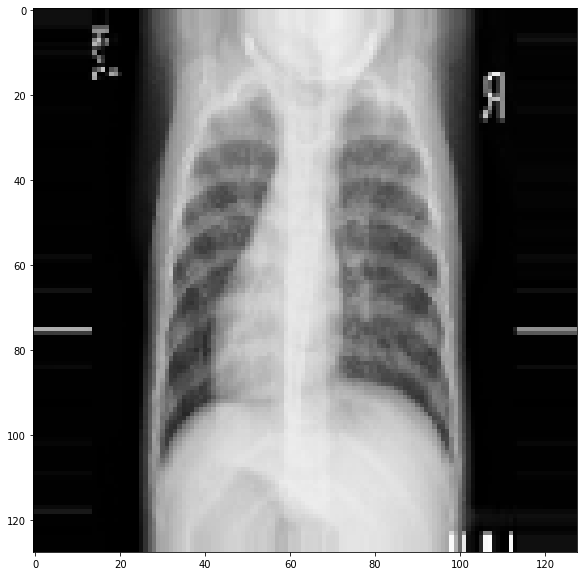

In [13]:
train_iter = iter(train_datagen)
train = train_iter.next()
print(train[1][0])
plt.figure(figsize=(10,10))
plt.imshow(train[0][0])

In [14]:
print("input size : ",input_size_1, input_size_2)
print("dim : ", dim)
print("kernel size : ", kernel_size)
print("Strides : ", strides)
print("output size : ", output_size)

input size :  128 128
dim :  3
kernel size :  (3, 3)
Strides :  (1, 1)
output size :  1


In [15]:
def input_size_sequential(input_size_1, input_size_2, dim):
    return (input_size_1, input_size_2, dim)

In [16]:
input_size_sequential(input_size_1, input_size_2, dim)

(128, 128, 3)

In [17]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = kernel_size, activation='relu', input_shape=input_size_sequential(input_size_1, input_size_2, dim)))
model.add(layers.Conv2D(32, kernel_size = kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(64, kernel_size = kernel_size, activation='relu'))
model.add(layers.Conv2D(64, kernel_size = kernel_size, activation='relu'))
model.add(layers.Conv2D(64, kernel_size = kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, kernel_size = kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Conv2D(128, kernel_size = kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Dropout(0.2))

# model.add(layers.Conv2D(256, kernel_size = kernel_size, activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(layers.Dropout(0.2))

model.add(layers.Flatten()) # 2d to 1d

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(output_size, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 64)        3

In [18]:
import tensorflow.keras as keras
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

#  keras.metrics.TruePositives(), keras.metrics.FalsePositives(), keras.metrics.TrueNegatives(), keras.metrics.FalseNegatives()

In [19]:
with tf.device('/GPU:0'):

    history = model.fit(train_datagen, epochs=epochs, 
                        validation_data=test_datagen)

Epoch 1/40
163/163 [==============================] - 58s 339ms/step - loss: 0.5815 - binary_accuracy: 0.7428 - recall: 0.9850 - auc: 0.5013 - val_loss: 0.6534 - val_binary_accuracy: 0.6250 - val_recall: 1.0000 - val_auc: 0.7120
Epoch 2/40
163/163 [==============================] - 54s 330ms/step - loss: 0.4953 - binary_accuracy: 0.7615 - recall: 0.9798 - auc: 0.7502 - val_loss: 0.3872 - val_binary_accuracy: 0.8189 - val_recall: 0.8385 - val_auc: 0.9093
Epoch 3/40
163/163 [==============================] - 54s 330ms/step - loss: 0.3399 - binary_accuracy: 0.8484 - recall: 0.9168 - auc: 0.9021 - val_loss: 0.4117 - val_binary_accuracy: 0.8189 - val_recall: 0.9385 - val_auc: 0.8991
Epoch 4/40
163/163 [==============================] - 54s 331ms/step - loss: 0.2878 - binary_accuracy: 0.8807 - recall: 0.9298 - auc: 0.9297 - val_loss: 0.3629 - val_binary_accuracy: 0.8381 - val_recall: 0.8974 - val_auc: 0.9159
Epoch 5/40
163/163 [==============================] - 54s 332ms/step - loss: 0.2974 

Epoch 37/40
163/163 [==============================] - 66s 406ms/step - loss: 0.1246 - binary_accuracy: 0.9500 - recall: 0.9652 - auc: 0.9863 - val_loss: 0.2154 - val_binary_accuracy: 0.9295 - val_recall: 0.9667 - val_auc: 0.9713
Epoch 38/40
163/163 [==============================] - 66s 402ms/step - loss: 0.1272 - binary_accuracy: 0.9544 - recall: 0.9650 - auc: 0.9853 - val_loss: 0.2227 - val_binary_accuracy: 0.9231 - val_recall: 0.9795 - val_auc: 0.9728
Epoch 39/40
163/163 [==============================] - 66s 402ms/step - loss: 0.1107 - binary_accuracy: 0.9579 - recall: 0.9698 - auc: 0.9896 - val_loss: 0.2846 - val_binary_accuracy: 0.9231 - val_recall: 0.9718 - val_auc: 0.9543
Epoch 40/40
163/163 [==============================] - 67s 409ms/step - loss: 0.1232 - binary_accuracy: 0.9550 - recall: 0.9657 - auc: 0.9875 - val_loss: 0.2230 - val_binary_accuracy: 0.9279 - val_recall: 0.9872 - val_auc: 0.9734


20/20 [==============================] - 5s 232ms/step - loss: 0.2230 - binary_accuracy: 0.9279 - recall: 0.9872 - auc: 0.9734


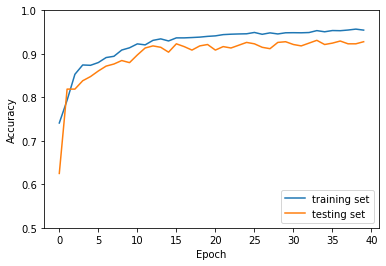

In [20]:
plt.plot(history.history['binary_accuracy'], label='training set')
plt.plot(history.history['val_binary_accuracy'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_binacc, test_recall, test_auc = model.evaluate(test_datagen)

20/20 [==============================] - 5s 238ms/step - loss: 0.2230 - binary_accuracy: 0.9279 - recall: 0.9872 - auc: 0.9734


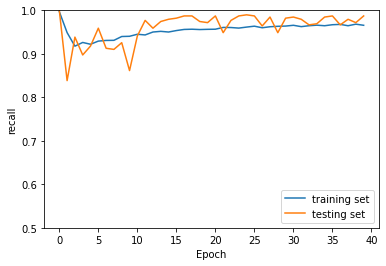

In [21]:
plt.plot(history.history['recall'], label='training set')
plt.plot(history.history['val_recall'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_binacc, test_recall, test_auc = model.evaluate(test_datagen)

20/20 [==============================] - 5s 232ms/step - loss: 0.2230 - binary_accuracy: 0.9279 - recall: 0.9872 - auc: 0.9734


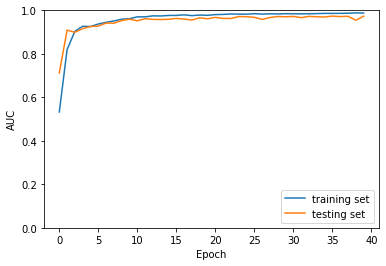

In [22]:
plt.plot(history.history['auc'], label='training set')
plt.plot(history.history['val_auc'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_binacc, test_recall, test_auc = model.evaluate(test_datagen)

In [38]:
# model.save('pneumonia_A927_R98_AUC97_128x128.h5')

In [24]:
# from tensorflow import keras
# model = keras.models.load_model('./model/pneumonia_A91_R96_AUC94_128x128.h5')

0.0


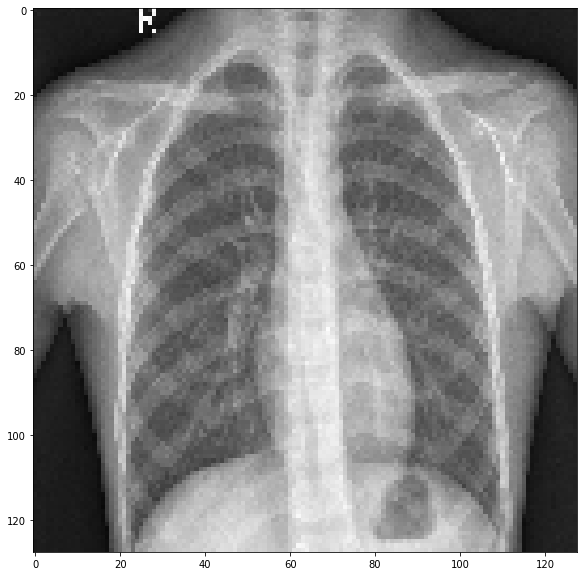

In [25]:
test_iter = iter(test_datagen)
test = test_iter.next()
print(test[1][0])
plt.figure(figsize=(10,10))
plt.imshow(test[0][0])

In [26]:
my_test = np.reshape(test[0][0], ( 1, *test[0][0].shape))

In [27]:
my_test.shape

(1, 128, 128, 3)

In [28]:
np.min(my_test)

0.03529412

In [29]:
np.max(my_test)

1.0

In [30]:
my_test.dtype

dtype('float32')

In [31]:
model.predict(my_test)

array([[0.01019563]], dtype=float32)

### confusion matrix

In [32]:
def one_or_zero(x:float):
    if x < 0.5:
        return 0
    else:
        return 1

Confusion Matrix
[[194  40]
 [  5 385]]


<AxesSubplot:>

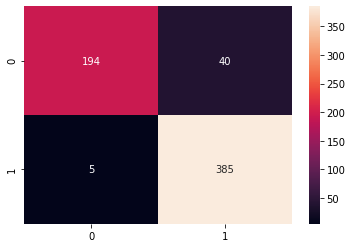

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Confution Matrix
Y_pred = model.predict(test_datagen)
y_pred = [one_or_zero(x) for x in Y_pred.squeeze()]
print('Confusion Matrix')
print(confusion_matrix(test_datagen.classes, y_pred))
cf_matrix = confusion_matrix(test_datagen.classes, y_pred)

sns.heatmap(cf_matrix, annot=True, fmt='g')


In [34]:
test_datagen.classes[1:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
# labels = []
# predictions = []
# iter_datagen = iter(test_datagen)
# for i in range(len(test_datagen)):
#     entry = iter_datagen.next()
#     labels.append(entry[1])
#     image = entry[0]
    
#     y_pred = model.predict(image)
#     predictions.append(one_or_zero(y_pred))

In [36]:
# print('Confusion Matrix')
# cf_matrix = confusion_matrix(labels, predictions)

# sns.heatmap(cf_matrix, annot=True, fmt='g')

In [37]:
# labels[1:10]